# Dance Dance Convolution - Revisited

Revision of the original "Dance Dance Convolution" paper, that incorporates newer machine learning and AI techniques to "hopefully" improve the original model results.

## Imports

In [1]:
import os 
import ffmpeg
from pathlib import Path
from collections import defaultdict
from os.path import isfile, join, splitext, basename, normpath, exists

import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display

# Custom Functions
from sm_parsing import stepfile_parser
from post_process import add_measure_timestamps, log_spectrogram

## Loading and Cleaning Dataset

In [2]:
# Path to dataset
base_path = "./dataset"

# Extension of the required stepfile
stepfile_ext = ".sm"

# Allowed audio and stepfile extensions
audio_exts = [".ogg", ".mp3", ".wav"]
steps_exts = [".sm", ".ssc"]

# Song packs inside dataset
# (Ignores files that are not directories)
song_packs = [f for f in os.listdir(base_path) if not isfile(join(base_path, f))]

print(f"Found a total of {len(song_packs)} song packs.")

# =======================================
# SONG PACK CLEANING AND DATA EXTRACTION
# =======================================

# Files that dont add anything to training are deleted (videos, images, txts, etc.)
# Wanted file extensions
wanted_ext = audio_exts + steps_exts

# Counter for the number of files deleted.
files_deleted = 0

# Counter for the number of songs encountered
songs_encountered = 0

# Dictionary that will get one entry for each pack
pack_data = {}

# For every song pack
for pack_name in song_packs:

    # Empty dict that stores all relevant filepaths for a song inside a pack
    # All unseen keys are assigned an empty list by default
    song_data = defaultdict(lambda: [])

    # Go through every file in the song pack
    # (including files and subfiles)
    for path, _, files in os.walk(join(base_path, pack_name)):

        # For every file inside the base path
        for file in files: 

            # Get the current file's parent folder (song folder)
            # 1. The absolute path for the parent directory is extracted
            # 2. 'normpath' strips off any trailing slashes
            # 3. 'basename' returns the last part of the path
            parent_name = basename(normpath(Path(path)))

            # If the file has a "pack_name" as a parent the file is outside 
            # a song folder, it is ignored as a result.
            if parent_name in song_packs:
                print(f"Found '{file}' outside of a song folder. Ignoring file.")
                continue

            # The file extension is extracted
            _, ext = splitext(file)

            # File is deleted if it has an unwanted extension
            if ext not in wanted_ext:
                try:
                    os.remove(join(path, file))
                    files_deleted += 1
                except Exception as e:
                    raise Exception(e)

            # All the paths that relate to a song are stored in a dict
            # according to their name and the songpack they belong to
            else:
                song_data[parent_name].append(join(path, file))
    
    # The "song_data" is stored inside the "pack_data"
    # (This is to prevent two packs having the same title for a
    # song and risking overwriting the data for one song.)
    pack_data[pack_name] = song_data

    # We add the number of songs in the pack to "songs_encountered"
    songs_encountered += len(list(song_data.keys()))

# Printout after cleaning
if files_deleted == 0:
    print(f"Dataset already clean. {songs_encountered} songs found. 0 files deleted.")
else:
    print(f"Dataset cleaned successfully. {songs_encountered} songs found. {files_deleted} files deleted.")


Found a total of 6 song packs.
Found 'group.ini' outside of a song folder. Ignoring file.
Dataset already clean. 230 songs found. 0 files deleted.


## Check if Songs Have Both Audio and Note Data

In [3]:
# Dict for the path of all audio files
audio_paths = defaultdict(dict)

# For every song in each pack
for pack_name in pack_data.keys():
    for song_name in pack_data[pack_name].keys():

        # We get all the extensions found for a song
        song_folder_exts = [splitext(path)[1] for path in pack_data[pack_name][song_name]]

        # Check one or more audio extensions were found inside the song folder
        audio_check = any([audio_ext in song_folder_exts for audio_ext in audio_exts])

        # Check if the required stepfile extension was found
        sm_check = stepfile_ext in song_folder_exts

        # If the song doesnt pass both checks, the song gets deleted from the dict
        if not(audio_check and sm_check):

            del pack_data[pack_name][song_name]
            print(f"Song '{song_name}' of pack '{pack_name}' does not contain one of the required files for training. Removing song from dataset.")

        else:
            # We extract the path for the songs audio file
            # A path is extracted only if it has one of the required extensions
            audio_path = [path for path in pack_data[pack_name][song_name] if splitext(path)[1] in audio_exts]

            # The path is added to an "audio files" dict
            audio_paths[pack_name][song_name] = audio_path


## Data Extraction from Stepfiles

In [4]:
# Counter for songs successfully processed
successfully_processed = 0

# Dict to store the tag data for each song in the pack 
dataset_tags = defaultdict(dict)

# For every pack in the dataset
for pack_name in pack_data.keys():
    
    # For every song in the song pack
    for song_name in pack_data[pack_name]: 

        try:
            # For every path corresponding to the current song, we take
            # the one that contains the extension that we need. Due to it being
            # returned inside of a list, we get the first element.
            stepfile_path = [path for path in pack_data[pack_name][song_name] if stepfile_ext in path][0]

        # If an error occurs while getting the stepfile path,
        # the program skips the current song
        except Exception:
            print(f"No '{stepfile_ext}' file found for song '{song_name}' in song pack '{pack_name}'. Skipping song.")
            continue

        # Step file content is extracted as text
        with open(stepfile_path, 'r', encoding="utf-8") as stepfile:
            stepfile_txt = stepfile.read()
            
        # The text of each song is parsed and turned into a dict of tags
        dataset_tags[pack_name][song_name] = stepfile_parser(stepfile_txt)

        # Required tags
        required_tags = ['offset', 'bpms', 'notes']

        # Current song tags
        current_tags = list(dataset_tags[pack_name][song_name].keys())

        # Check if resulting dictionary keys contain all the required tags
        if not all((item in current_tags) for item in required_tags):
            raise Exception(f"Song '{song_name}' of pack '{pack_name}' does not contain all of the required tags: 'offset', 'bpms' and 'notes'.")

        # Increase the number of files succesfully processed
        else:
            successfully_processed += 1

# Successful files
print(f"Number of succesfully processed songs: {successfully_processed} / {songs_encountered}")

Number of succesfully processed songs: 230 / 230


## Add Timestamps to all Charts

In [5]:
# Dictionary to store the processed data
measure_data = defaultdict(dict)

# For every pack in the dataset
for pack_name in dataset_tags.keys():
    
    # For every song in the song pack
    for song_name in dataset_tags[pack_name].keys(): 

        # We store the post-processed measures
        measure_data[pack_name][song_name] = {"measures": add_measure_timestamps(dataset_tags[pack_name][song_name])}


## Audio to Spectrogram

Based off the following article: https://towardsdatascience.com/getting-to-know-the-mel-spectrogram-31bca3e2d9d0

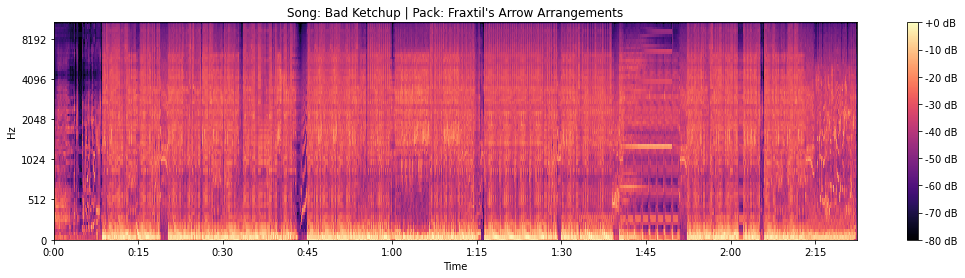

In [42]:
pack_name = "Fraxtil's Arrow Arrangements"
song_name = "Bad Ketchup"

# Extract the path to the song's audio
audio_path = audio_paths[pack_name][song_name][0]

# Audio gets loaded
raw_audio, sample_rate = librosa.load(audio_path)

# Hyperparameters for Librosas's STFT
# Both the window size and the stride are given in miliseconds.
# "n_mels" consists of the number of frequency bins that the user after applying the "Mel Scale".
# We use three different window sizes to capture different amounts of "detail" in the signal.
window_sizes = [23, 46, 93]            
stride = 10
n_mels = 80

# 3D tensor for the all the STFT results after using each window size
audio_data = []

# For every window size (in ms)
for window_size in window_sizes:

    # Calculate parameters for Short Time Fourier Transform (STFT)
    n_fft      = int(round(window_size * sample_rate / 1e3))
    hop_length = int(round(     stride * sample_rate / 1e3))

    # Spectrogram is generated
    spectrogram = librosa.feature.melspectrogram(raw_audio, sr=sample_rate, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)

    # Spectrogram gets scaled into decibels
    spectrogram_db = librosa.power_to_db(spectrogram, ref=np.max)
    audio_data.append(spectrogram_db.T)

# Resize array to have the shape: (Time x N Mel x 3)
audio_data = np.reshape(np.array(audio_data), (-1, n_mels, 3))

# Final spectrogram visualization
plt.figure(figsize=(18,4))
librosa.display.specshow(spectrogram_db, sr=sample_rate, hop_length=hop_length, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title(f"Song: {song_name} | Pack: {pack_name}")
plt.show()